# "A Simple and Reliable Way to Compute Option-Based Risk-Neutral Distributions"

## https://www.newyorkfed.org/medialibrary/media/research/staff_reports/sr677.pdf

Implementing the methodology described for exchange traded products

---

## Import external libraries

In [132]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Example volatility data (page 13 of paper)

In [162]:
lst = [
    [80.0, 23.95],
    [90.0, 21.71],
    [95.0, 18.81],
    [97.5, 17.40],
    [100.0, 16.09],
    [102.5, 14.88],
    [105.0, 13.84],
    [110.0, 12.48],
    [120.0, 12.34],
]

df = pd.DataFrame(lst, columns=['moneyness', 'implied_vol']).set_index('moneyness')
rg = np.linspace(70, 130, 100) # range for interpolation

## Intialising clamped CubicSpline function

clamped_cubic is a wrapper on CubicSpline in order to allow for flat extrapolation beyond the two end knots.

In [163]:
f = CubicSpline(df.index, df['implied_vol'], bc_type='clamped')

def clamped_cubic(X, boundary=(None, None)):
    """
    Adjusts scipy's CubicSpline method to provide flat extrapolation.
    
    Parameters
    ----------
    X = list of interpolation points
    boundary = tuple of lower and upper values for flat extrapolation
    """
    
    lower, upper = boundary
    f = CubicSpline(df.index, df['implied_vol'], bc_type='clamped')
    res = []
    for x in X:
        if x < lower:
            res.append(f(lower))
        elif x > upper:
            res.append(f(upper))
        else:
            res.append(f(x))
    return res

## Plot interpolated / extrapolated volatility smile

Wall time: 78.2 ms


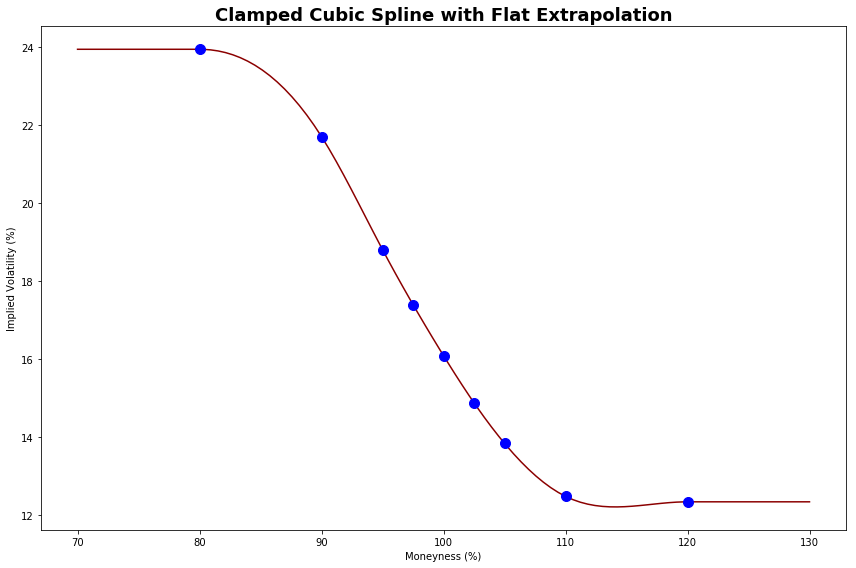

In [164]:
%%time
plt.figure(figsize=(12, 8))
plt.plot(rg, clamped_cubic(rg, boundary=(df.index[0], df.index[-1])), color='darkred', label='spline')
plt.plot(df.index, df['implied_vol'], color='b', marker='o', linestyle="", markersize=10)
plt.title('Clamped Cubic Spline with Flat Extrapolation', fontweight='bold', fontsize='18')
plt.ylabel('Implied Volatility (%)')
plt.xlabel('Moneyness (%)')
plt.tight_layout();

## Implementation of Black-Scholes European Call pricing function

In [165]:
def bs_call(K,T,r,d,v):
    """
    Black-Scholes Call Price.
    
    Parameters:
    K = strike moneyness percent (80% = 80)
    T = years to maturity
    r = annualised continuously compounded risk-free rate with tenor T
    d = annualised continuously compounded dividend yield over tenot T
    v = implied volatility
    """
    
    S=100
    d1 = (np.log(float(S)/K)+((r-d)+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    
    return S*np.exp(-d*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

## Example parameters to create call prices from volatily smile

In [166]:
T = 0.25
r = 0.00058
d = 0.02306